<h1 align= center> Taller 1: Modelos de Regresión para la Predicción de Demanda de Bicicletas Compartidas</h1>

### Integrantes

- Axel Mondaca
- Sebastían Hernández

<h4 align = center> Importación de librerias <h4>

In [301]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from prettytable import PrettyTable

In [302]:
df = pd.read_csv ('bike_sharing_data.csv')
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


<h2 align = center> Ingeniería de características y exploración </h2>

Apartado de división de de datos y extracción de características temporales

In [303]:
df['day'] = df['dteday'].str.split('-').str[2].astype(int)

train = df[df['day'] <=14].copy()
val = df[(df['day'] >= 15) & (df['day'] <= 21)].copy()
test = df[df['day'] >= 22].copy()

df['year'] = df['dteday'].str.split('-').str[0].astype(int)
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
df['is_rush_hour'] = df['hr'].isin([7, 8, 9, 17, 18, 19]).astype(int)
df['hour_category'] = pd.cut(df['hr'], 
                            bins=[0, 6, 12, 18, 24],
                            labels=[1, 2, 3, 4], right=False)
df

for d in [train, val, test]:
    d.sort_values('dteday', inplace=True)
    d.reset_index(drop=True, inplace=True)

print("Sizes:", len(train), len(val), len(test))
display(train.describe(include='all'))

Sizes: 8026 4008 5345


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day
count,8026.000000,8026,8026.000000,8026.000000,8026.000000,8026.000000,8026.000000,8026.000000,8026.000000,8026.000000,8026.000000,8026.000000,8026.000000,8026.000000,8026.000000,8026.000000,8026.000000,8026.000000
unique,NaN,336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2012-12-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,8471.238973,NaN,2.505607,0.501495,6.517568,11.538874,0.026788,3.002492,0.686768,1.411039,0.489958,0.470477,0.616605,0.189599,35.340892,154.402816,189.743708,7.496885
std,5028.466131,NaN,1.116640,0.500029,3.446648,6.915569,0.161473,2.001182,0.463837,0.636480,0.196756,0.175227,0.196482,0.122830,48.925630,150.940044,180.277213,4.032182
min,1.000000,NaN,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.015200,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,4269.250000,NaN,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.460000,0.104500,4.000000,35.000000,41.000000,4.000000
50%,8657.500000,NaN,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.480000,0.469700,0.610000,0.164200,16.000000,117.000000,143.000000,7.000000
75%,13011.750000,NaN,4.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,221.000000,282.000000,11.000000


<h4 align= center> Análisis exploratorio </h4>

In [304]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
instant,17379.0,8690.000000,5017.029500,1.00,4345.5000,8690.0000,13034.5000,17379.0000
season,17379.0,2.501640,1.106918,1.00,2.0000,3.0000,3.0000,4.0000
yr,17379.0,0.502561,0.500008,0.00,0.0000,1.0000,1.0000,1.0000
mnth,17379.0,6.537775,3.438776,1.00,4.0000,7.0000,10.0000,12.0000
hr,17379.0,11.546752,6.914405,0.00,6.0000,12.0000,18.0000,23.0000
holiday,17379.0,0.028770,0.167165,0.00,0.0000,0.0000,0.0000,1.0000
weekday,17379.0,3.003683,2.005771,0.00,1.0000,3.0000,5.0000,6.0000
workingday,17379.0,0.682721,0.465431,0.00,0.0000,1.0000,1.0000,1.0000
weathersit,17379.0,1.425283,0.639357,1.00,1.0000,1.0000,2.0000,4.0000
temp,17379.0,0.496987,0.192556,0.02,0.3400,0.5000,0.6600,1.0000


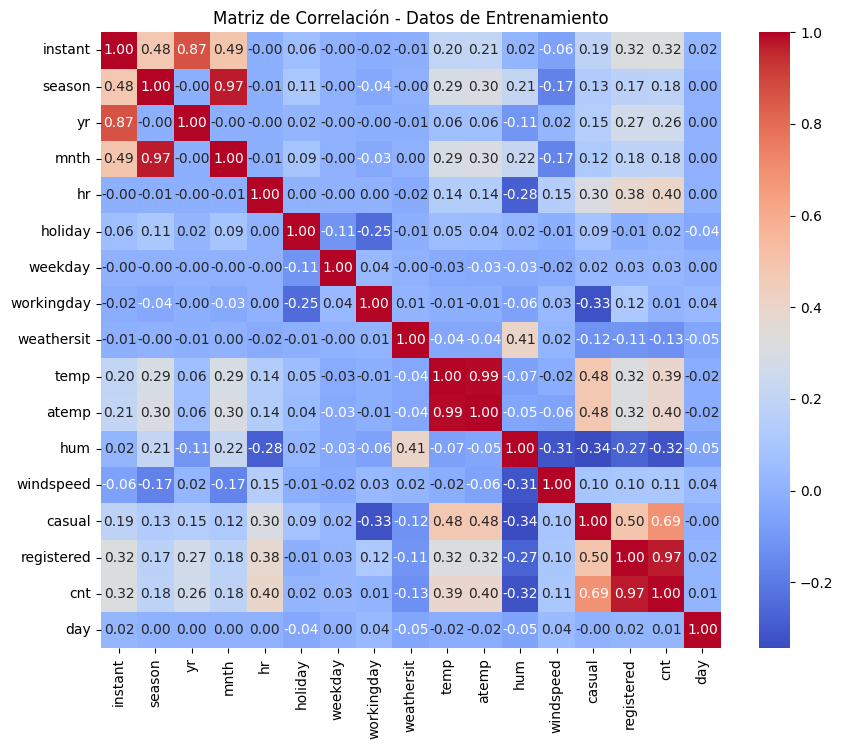

In [305]:
plt.figure(figsize=(10,8))
numeric_cols = train.select_dtypes(include=['number']).columns
sns.heatmap(train[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matriz de Correlación - Datos de Entrenamiento')
plt.show()

Text(0, 0.5, 'Frecuencia')

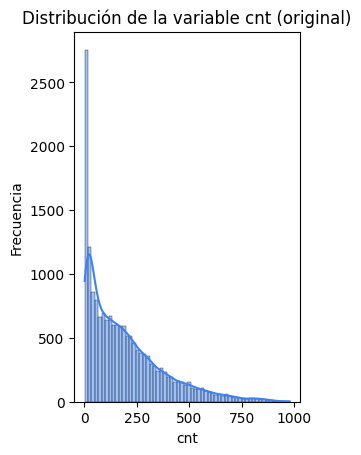

In [306]:
plt.subplot(1,2,1)
sns.histplot(df['cnt'], bins=60, kde=True, color='#3b82f6')
plt.title('Distribución de la variable cnt (original)')
plt.xlabel('cnt')
plt.ylabel('Frecuencia')

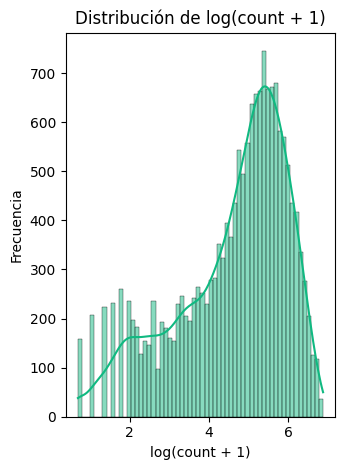

In [307]:
import numpy as np

plt.subplot(1,2,2)
sns.histplot(np.log1p(df['cnt']), bins=60, kde=True, color='#10b981')
plt.title('Distribución de log(count + 1)')
plt.xlabel('log(count + 1)')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [308]:
skew_original = df['cnt'].skew()
skew_log = np.log1p(df['cnt']).skew()

print(f"Asimetría (skewness) original: {skew_original:.3f}")
print(f"Asimetría (skewness) log(count+1): {skew_log:.3f}")

Asimetría (skewness) original: 1.277
Asimetría (skewness) log(count+1): -0.818


Comparando los gráficos de la variable count original con la distribución log(count+1), se puede observar que los datos se va normalizando quedando aproximadamente en 5, logrando así menor sesgo.

<h3 align= center> Demanda por hora</h3>

Text(0, 0.5, 'Bicicletas alquiladas')

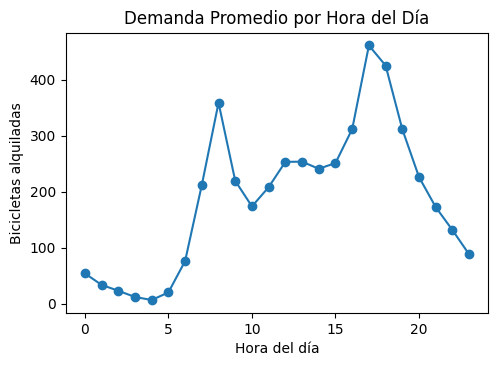

In [309]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
demanda_hora = df.groupby('hr')['cnt'].mean()
plt.plot(demanda_hora.index, demanda_hora.values, marker='o')
plt.title('Demanda Promedio por Hora del Día')
plt.xlabel('Hora del día')
plt.ylabel('Bicicletas alquiladas')

<h3 align= center> Demanda por día de semana</h3>

Text(0.5, 1.0, 'Demanda Promedio por Día de la Semana')

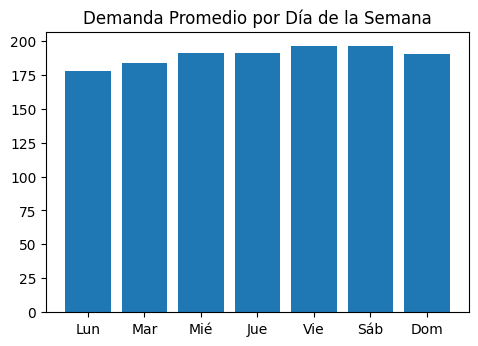

In [310]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,2)
demanda_dia = df.groupby('weekday')['cnt'].mean()
dias = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
plt.bar(dias, demanda_dia.values)
plt.title('Demanda Promedio por Día de la Semana')

<h3 align=center> Temperatura vs Demanda</h3>

Text(0, 0.5, 'Bicicletas alquiladas')

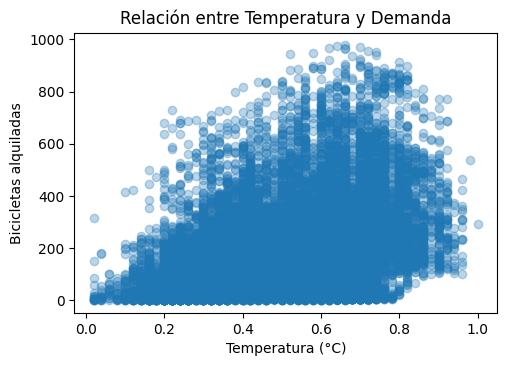

In [311]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,3)
plt.scatter(df['temp'], df['cnt'], alpha=0.3)
plt.title('Relación entre Temperatura y Demanda')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Bicicletas alquiladas')

<h3 align= center> Boxplot por condición climática</h3>

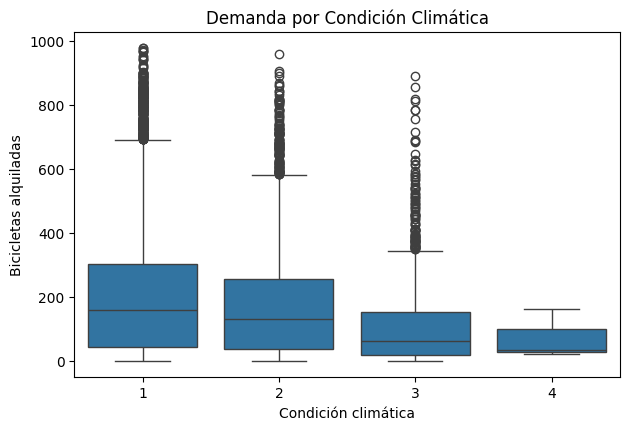

In [312]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,4)
sns.boxplot(x='weathersit', y='cnt', data=df)
plt.title('Demanda por Condición Climática')
plt.xlabel('Condición climática')
plt.ylabel('Bicicletas alquiladas')

plt.tight_layout()
plt.show()

In [313]:
print("Valores faltantes por columna:")
print(df.isnull().sum())


Valores faltantes por columna:
instant          0
dteday           0
season           0
yr               0
mnth             0
hr               0
holiday          0
weekday          0
workingday       0
weathersit       0
temp             0
atemp            0
hum              0
windspeed        0
casual           0
registered       0
cnt              0
day              0
year             0
is_weekend       0
is_rush_hour     0
hour_category    0
dtype: int64


In [314]:
print("\nRango de variables:")
print(f"Temperatura: {df['temp'].min()} - {df['temp'].max()}°C")
print(f"Humedad: {df['hum'].min()} - {df['hum'].max()}%")
print(f"Velocidad viento: {df['windspeed'].min()} - {df['windspeed'].max()}")


Rango de variables:
Temperatura: 0.02 - 1.0°C
Humedad: 0.0 - 1.0%
Velocidad viento: 0.0 - 0.8507


<h2 align= center> Variable objetivo: Count</h2>

In [315]:
df['log_count'] = np.log1p(df['cnt'])

print("Comparación de distribuciones:")
print(f"Skewness count original: {df['cnt'].skew():.2f}")
print(f"Skewness log_count: {df['log_count'].skew():.2f}")

Comparación de distribuciones:
Skewness count original: 1.28
Skewness log_count: -0.82


Normalización de variables

In [316]:
numeric_vars = ['temp', 'atemp', 'hum', 'windspeed', 'hr', 'weekday', 'mnth']

# Ensure 'log_count' exists in train, val, and test
for d in [train, val, test]:
	if 'log_count' not in d.columns:
		d['log_count'] = np.log1p(d['cnt'])

y_train = train['log_count']
y_val = val['log_count']
y_test = test['log_count']

y_train_original = train['cnt']
y_val_original = val['cnt']
y_test_original = test['cnt']

scaler = StandardScaler()
scaler.fit(train[numeric_vars])

X_train_scaled = scaler.transform(train[numeric_vars])
X_val_scaled = scaler.transform(val[numeric_vars])
X_test_scaled = scaler.transform(test[numeric_vars])

In [317]:
# Resumen de variables disponibles después de la preparación
print("\n--- VARIABLES DISPONIBLES PARA MODELADO ---")
print("Conjuntos de características (ya normalizadas):")
print(f"• X_train_scaled: {X_train_scaled.shape}")
print(f"• X_val_scaled: {X_val_scaled.shape}") 
print(f"• X_test_scaled: {X_test_scaled.shape}")

print("\nVariables objetivo (transformación logarítmica):")
print(f"• y_train: {y_train.shape}")
print(f"• y_val: {y_val.shape}")
print(f"• y_test: {y_test.shape}")




--- VARIABLES DISPONIBLES PARA MODELADO ---
Conjuntos de características (ya normalizadas):
• X_train_scaled: (8026, 7)
• X_val_scaled: (4008, 7)
• X_test_scaled: (5345, 7)

Variables objetivo (transformación logarítmica):
• y_train: (8026,)
• y_val: (4008,)
• y_test: (5345,)


<h3 align=center> Regresión lineal </h3>

In [318]:
variables_originales = ['season', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']

# Selecciona las columnas originales de los DataFrames
X_train_base = train[variables_originales]
X_val_base = val[variables_originales]

y_train_base = y_train_original
y_val_base = y_val_original

modelo_base = LinearRegression()
modelo_base.fit(X_train_base, y_train_base)

print(f"Coeficientes: {len(modelo_base.coef_)}")
print(f"Intercepto: {modelo_base.intercept_:.4f}")


Coeficientes: 8
Intercepto: 114.7892


Predecir en validación

In [319]:
from sklearn.metrics import mean_absolute_error

y_pred_val = modelo_base.predict(X_val_base)

mse = mean_squared_error(y_val_base, y_pred_val)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val_base, y_pred_val)
r2 = r2_score(y_val_base, y_pred_val)

print("Métricas en escala original (count):")
print(f"• MSE:  {mse:.4f}")
print(f"• RMSE: {rmse:.4f}")
print(f"• MAE:  {mae:.4f}")
print(f"• R²:   {r2:.4f}")

Métricas en escala original (count):
• MSE:  26247.3743
• RMSE: 162.0104
• MAE:  121.1128
• R²:   0.2149


<h3 align=center> Modelo mejorado</h3>

In [320]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd
# Ensure 'is_weekend' and 'is_rush_hour' exist in train and val
if 'is_weekend' not in train.columns:
    train['is_weekend'] = train['weekday'].isin([5, 6]).astype(int)
if 'is_rush_hour' not in train.columns:
    train['is_rush_hour'] = train['hr'].isin([7, 8, 9, 17, 18, 19]).astype(int)
if 'is_weekend' not in val.columns:
    val['is_weekend'] = val['weekday'].isin([5, 6]).astype(int)
if 'is_rush_hour' not in val.columns:
    val['is_rush_hour'] = val['hr'].isin([7, 8, 9, 17, 18, 19]).astype(int)

caracteristicas_completas = [
    'season', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
    'hr', 'weekday', 'mnth', 'is_weekend', 'is_rush_hour'
]

X_train_mejorado = train[caracteristicas_completas]
X_val_mejorado = val[caracteristicas_completas]

y_train_mejorado = y_train_original
y_val_mejorado = y_val_original

In [321]:
modelo_mejorado = LinearRegression()
modelo_mejorado.fit(X_train_mejorado, y_train_mejorado)

print(f"Coeficientes: {len(modelo_mejorado.coef_)}")
print(f"Intercepto: {modelo_mejorado.intercept_:.4f}")

Coeficientes: 13
Intercepto: -2.0718


In [322]:
y_pred_mejorado = modelo_mejorado.predict(X_val_mejorado)

mse_mejorado = mean_squared_error(y_val_mejorado, y_pred_mejorado)
rmse_mejorado = np.sqrt(mse_mejorado)
mae_mejorado = mean_absolute_error(y_val_mejorado, y_pred_mejorado)
r2_mejorado = r2_score(y_val_mejorado, y_pred_mejorado)

print("Métricas del Modelo Mejorado:")
print(f"• MSE:  {mse_mejorado:.4f}")
print(f"• RMSE: {rmse_mejorado:.4f}")
print(f"• MAE:  {mae_mejorado:.4f}")
print(f"• R²:   {r2_mejorado:.4f}")

Métricas del Modelo Mejorado:
• MSE:  17338.0655
• RMSE: 131.6741
• MAE:  95.8657
• R²:   0.4814


In [323]:
# Definir el diccionario de métricas para el modelo base
metricas_modelo_base = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2
}

comparacion_metricas = pd.DataFrame({
    'Métrica': ['MSE', 'RMSE', 'MAE', 'R²'],
    'Modelo Base': [metricas_modelo_base['MSE'], metricas_modelo_base['RMSE'], 
                   metricas_modelo_base['MAE'], metricas_modelo_base['R2']],
    'Modelo Mejorado': [mse_mejorado, rmse_mejorado, mae_mejorado, r2_mejorado],
    'Mejora': [metricas_modelo_base['MSE'] - mse_mejorado, 
               metricas_modelo_base['RMSE'] - rmse_mejorado,
               metricas_modelo_base['MAE'] - mae_mejorado,
               r2_mejorado - metricas_modelo_base['R2']]
})

comparacion_metricas['Mejora %'] = (comparacion_metricas['Mejora'] / comparacion_metricas['Modelo Base']) * 100
print(comparacion_metricas.round(4))

  Métrica  Modelo Base  Modelo Mejorado     Mejora  Mejora %
0     MSE   26247.3743       17338.0655  8909.3088   33.9436
1    RMSE     162.0104         131.6741    30.3363   18.7249
2     MAE     121.1128          95.8657    25.2471   20.8459
3      R²       0.2149           0.4814     0.2665  123.9734


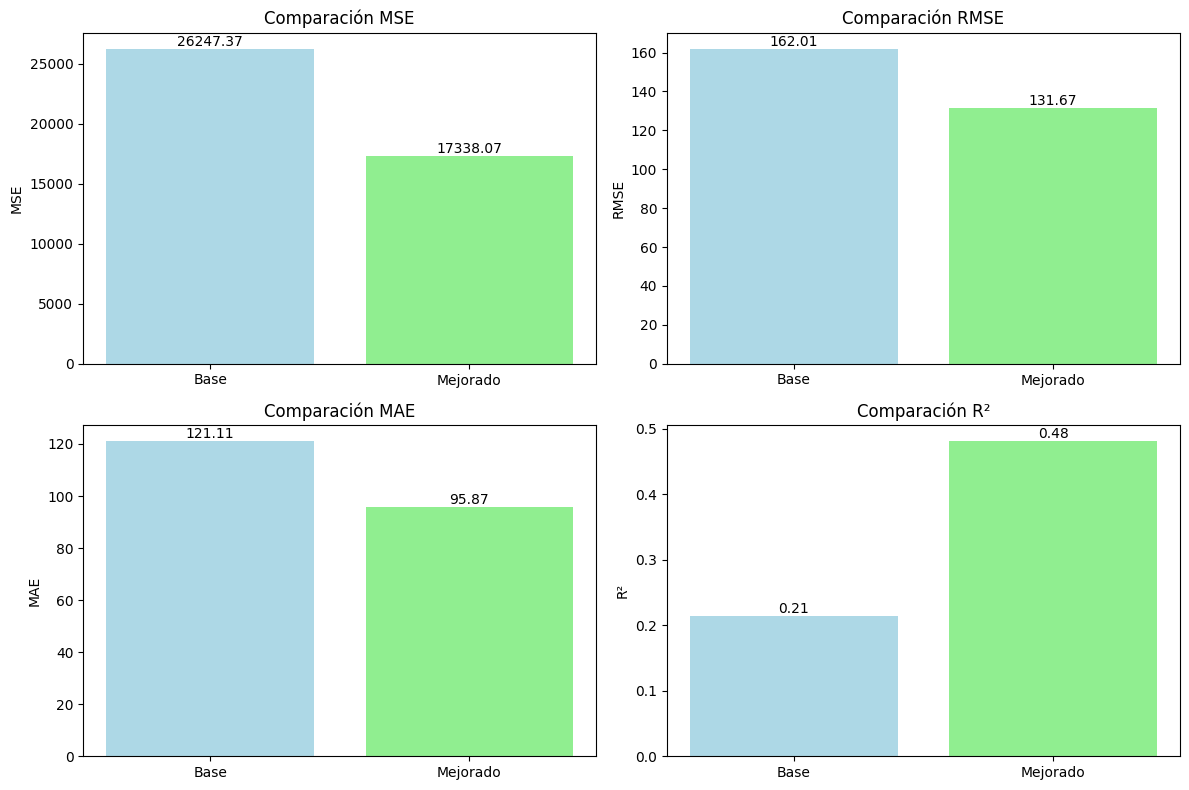

In [324]:
metricas_comp = comparacion_metricas['Métrica'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, metrica in enumerate(metricas_comp):
    row, col = i // 2, i % 2
    valores = [comparacion_metricas.loc[i, 'Modelo Base'], comparacion_metricas.loc[i, 'Modelo Mejorado']]
    bars = axes[row, col].bar(['Base', 'Mejorado'], valores, color=['lightblue', 'lightgreen'])
    axes[row, col].set_title(f'Comparación {metrica}')
    axes[row, col].set_ylabel(metrica)
    
    # Añadir valores en las barras
    for bar, valor in zip(bars, valores):
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width()/2., height,
                          f'{valor:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [325]:

# Calcular VIF para las variables del modelo mejorado
X_vif = add_constant(X_train_mejorado)
vif_data = pd.DataFrame({
	'Variable': X_train_mejorado.columns,
	'VIF': [variance_inflation_factor(X_vif.values, i+1) for i in range(len(X_train_mejorado.columns))]
})

temp_vif = vif_data[vif_data['Variable'] == 'temp']['VIF'].values[0]
atemp_vif = vif_data[vif_data['Variable'] == 'atemp']['VIF'].values[0]

print(temp_vif, atemp_vif)

74.42828565356847 74.81356647383775


# Regularización: LASSO y Ridge


<h3 align=center> Ridge </h3>


In [326]:
l2_optimizer = GridSearchCV(Ridge(), {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, cv=5, scoring='r2') # modelo 
l2_optimizer.fit(X_train_mejorado, y_train_mejorado) # dobleces de la validación cruzada
l2_optimizer.best_params_

{'alpha': 100}

In [327]:
L2 = Ridge(alpha=l2_optimizer.best_params_["alpha"])
L2.fit(X_train_mejorado, y_train_mejorado)
y_pred = L2.predict(X_val_mejorado)
print(f'MSE: {mean_squared_error(y_val_mejorado, y_pred)}')
print(f'R^2: {r2_score(y_val_mejorado, y_pred)}')
ridge_mse = mean_squared_error(y_val_mejorado, y_pred)
ridge_r2 = r2_score(y_val_mejorado, y_pred)
rmse_ridge = np.sqrt(ridge_mse)
mae_ridge = mean_absolute_error(y_val_mejorado, y_pred)

MSE: 17050.240322478592
R^2: 0.49003048427724594


<h3 align=center> LASSO</h3>

In [330]:
lasso_optimizer = GridSearchCV(Lasso(), {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, cv=5, scoring='r2') # modelo 
lasso_optimizer.fit(X_train_mejorado, y_train_mejorado) # dobleces de la validación cruzada
lasso_optimizer.best_params_

{'alpha': 0.1}

In [332]:
L1 = Lasso(alpha=lasso_optimizer.best_params_["alpha"])
L1.fit(X_train_mejorado, y_train_mejorado)
y_pred = L1.predict(X_val_mejorado)
print(f'MSE: {mean_squared_error(y_val_mejorado, y_pred)}')
print(f'R^2: {r2_score(y_val_mejorado, y_pred)}')
L1_MSE = mean_squared_error(y_val_mejorado, y_pred)
L1_R2 = r2_score(y_val_mejorado, y_pred)
rmse_LASSO = np.sqrt(L1_MSE)
mae_LASSO = mean_absolute_error(y_val_mejorado, y_pred)

MSE: 16822.9806868081
R^2: 0.4968277776968242


In [334]:
table = PrettyTable()
table.field_names = ["Modelo", "MSE", "rmse", "mae", "R2"]
table.add_row(["Regresión lineal", mse, rmse, mae, r2])
table.add_row(["Lasso", L1_MSE, rmse_LASSO, mae_LASSO, L1_R2])
table.add_row(["Ridge", ridge_mse, rmse_ridge, mae_ridge, ridge_r2])
table

Modelo,MSE,rmse,mae,R2
Regresión lineal,26247.374293204673,162.01041415046342,121.11277308299455,0.21494591840722976
Lasso,16822.9806868081,129.70343359683312,94.6100778969644,0.4968277776968242
Ridge,17050.240322478592,130.57656881109486,94.93987268377313,0.49003048427724594


# Elastic Net y Análisis Avanzado


<h3 align=center> ElasticNet</h3>

In [335]:
l1_optimizer = GridSearchCV(val, {'alpha': [0.1, 0.3, 0.5, 0.7, 0.9]}, cv=5, scoring='r2') # modelo 
l2_optimizer.fit(X_train_mejorado, y_train_mejorado) # dobleces de la validación cruzada
l2_optimizer.best_params_


{'alpha': 100}

In [337]:
from sklearn.linear_model import ElasticNet

param_grid = {
	'alpha': [0.001, 0.01, 0.1, 1, 10],
	'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}
elasticnet_optimizer = GridSearchCV(ElasticNet(max_iter=10000), param_grid, cv=5, scoring='r2')
elasticnet_optimizer.fit(X_train_mejorado, y_train_mejorado)

L3 = ElasticNet(alpha=elasticnet_optimizer.best_params_["alpha"],
				l1_ratio=elasticnet_optimizer.best_params_["l1_ratio"],
				max_iter=10000)
L3.fit(X_train_mejorado, y_train_mejorado)
y_pred = L3.predict(val[caracteristicas_completas])

print(f'MSE: {mean_squared_error(y_val_mejorado, y_pred)}')
print(f'R^2: {r2_score(y_val_mejorado, y_pred)}')
ElasticNet_mse = mean_squared_error(y_val_mejorado, y_pred)
ElasticNet_r2 = r2_score(y_val_mejorado, y_pred)

MSE: 16986.136240570933
R^2: 0.4919478254400682


<h3 align=center> Análisis de residuos y patrones temporales </h3>

# Conclusiones y Recomendaciones
